In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pandas import *
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
def normalizeAB(a,b,x):
    minX=x.min()
    maxX=x.max()
    return (b-a)*((x-minX)/(maxX-minX))+a

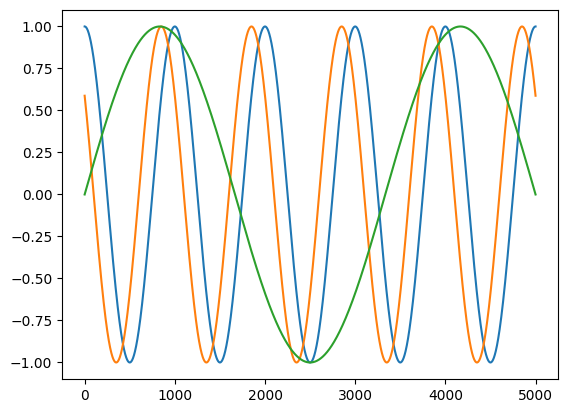

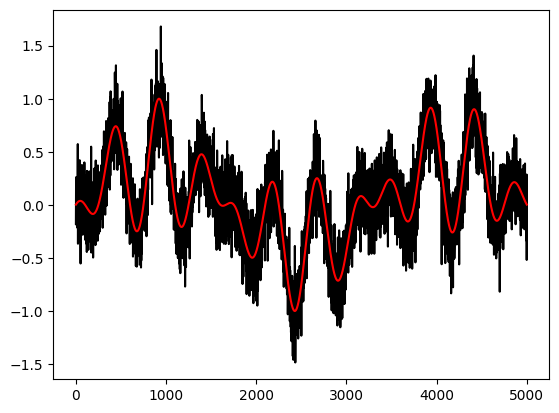

In [ ]:
x=linspace(0,numpy.pi*10,5001)
A=numpy.cos(x)
B=numpy.cos(x+numpy.pi*0.3)
C=numpy.cos((x+numpy.pi*5)*0.3)
plot(A)
plot(B)
plot(C)
figure()
rawData=normalizeAB(-1,1,A*B*C)
noise=numpy.random.normal(0,0.2,5001)
data=rawData+noise
plot(data,'k')
plot(rawData,'r')

#Data Splitting and Normalisation

In [ ]:
#Split the data into training and test sets
train_data = data[:3000]
test_data = data[3000:]


In [ ]:
normalised_train = normalizeAB(-1,1,train_data)
normalised_test = normalizeAB(-1,1,test_data)


#Train and Test Sequences

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        seq = input_data[i:i+tw]
        label = input_data[i+tw:i+tw+1]
        inout_seq.append((seq.flatten() ,label))
    return inout_seq

In [ ]:
window_3 = 3
window_30 = 30
window_100 = 100
window_300 = 300

#Training Sequence
train_inout_seq_3 = create_inout_sequences(numpy.array(normalised_train), window_3)
train_inout_seq_30 = create_inout_sequences(numpy.array(normalised_train), window_30)
train_inout_seq_100 = create_inout_sequences(numpy.array(normalised_train), window_100)
train_inout_seq_300 = create_inout_sequences(numpy.array(normalised_train), window_300)

#Testing Sequence
test_inout_seq_3 = create_inout_sequences(numpy.array(normalised_test), window_3)
test_inout_seq_30 = create_inout_sequences(numpy.array(normalised_test), window_30)
test_inout_seq_100 = create_inout_sequences(numpy.array(normalised_test), window_100)
test_inout_seq_300 = create_inout_sequences(numpy.array(normalised_test), window_300)

In [ ]:
test_inout_seq_300

#Models

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(RNN,self).__init__()
        self.hidden_layer_size=hidden_layer_size
        nr_of_layers_in_rnn=1

        self.rnn=nn.RNN(input_size,self.hidden_layer_size,nr_of_layers_in_rnn,
                        batch_first=True, nonlinearity='tanh')
        self.linear = nn.Linear(hidden_layer_size,output_size)

    def forward(self,input_seq):
        h0= torch.zeros(1,1,self.hidden_layer_size)
        rnn_out,h0 = self.rnn(input_seq,h0)
        out=self.linear(rnn_out)
        return out[0][-1]

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM,self).__init__()
        self.hidden_layer_size=hidden_layer_size
        nr_of_layers_in_lstm=1

        self.lstm=nn.LSTM(input_size,self.hidden_layer_size,nr_of_layers_in_lstm,
                        batch_first=True)

        self.linear = nn.Linear(hidden_layer_size,output_size)

    def forward(self,input_seq):
        h0= (torch.zeros(1,1,self.hidden_layer_size),
             torch.zeros(1,1,self.hidden_layer_size))
        lstm_out,h0 = self.lstm(input_seq,h0)
        out=self.linear(lstm_out)
        return out[0][-1]


In [ ]:
RNN_model = RNN()
loss_function = nn.MSELoss()
RNN_optimizer = torch.optim.Adam(RNN_model.parameters())
#RNN_optimizer = torch.optim.SGD(RNN_model.parameters(), lr=0.001)


In [ ]:
LSTM_model = LSTM()
loss_function = nn.MSELoss()
LSTM_optimizer = torch.optim.Adam(LSTM_model.parameters())
#optimizer = torch.optim.SGD(LSTM_model.parameters(), lr=0.001)

#Train and Test

In [ ]:
import matplotlib.pyplot as plt

def train_and_plot_losses(model, train_data, test_data, loss_function, optimizer, n_epochs, window_size):
    def train(model, train_data, loss_function, optimizer, window_size):
        model.train()
        train_loss = 0

        for seq, labels in train_data:
            optimizer.zero_grad()
            y_pred = model(torch.Tensor(seq.reshape(1, window_size, 1)))
            loss = loss_function(y_pred, torch.Tensor(labels))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        return train_loss / len(train_data)

    def test(model, test_data, loss_function, window_size):
        model.eval()
        test_loss = 0

        with torch.no_grad():
            for seq, labels in test_data:
                y_pred = model(torch.Tensor(seq.reshape(1, window_size, 1)))
                loss = loss_function(y_pred, torch.Tensor(labels))
                test_loss += loss.item()

        return test_loss / len(test_data)

    train_losses = []
    test_losses = []
    print('Window Size:',window_size)
    for epoch in range(1, n_epochs + 1):
        train_loss = train(model, train_data, loss_function, optimizer, window_size)
        test_loss = test(model, test_data, loss_function, window_size)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch}/{n_epochs}] - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}')

    # Plot the train and test losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Testing Losses for Window Size {window_size}')
    plt.legend()
    plt.show()



#Plots of Train and Test loss for Window Size

Window Size: 3
Epoch [1/10] - Train Loss: 0.0191 - Test Loss: 0.1729
Epoch [2/10] - Train Loss: 0.0209 - Test Loss: 0.1615
Epoch [3/10] - Train Loss: 0.0212 - Test Loss: 0.1591
Epoch [4/10] - Train Loss: 0.0213 - Test Loss: 0.1577
Epoch [5/10] - Train Loss: 0.0209 - Test Loss: 0.1519
Epoch [6/10] - Train Loss: 0.0204 - Test Loss: 0.1413
Epoch [7/10] - Train Loss: 0.0199 - Test Loss: 0.1353
Epoch [8/10] - Train Loss: 0.0195 - Test Loss: 0.1184
Epoch [9/10] - Train Loss: 0.0192 - Test Loss: 0.1164
Epoch [10/10] - Train Loss: 0.0190 - Test Loss: 0.1124


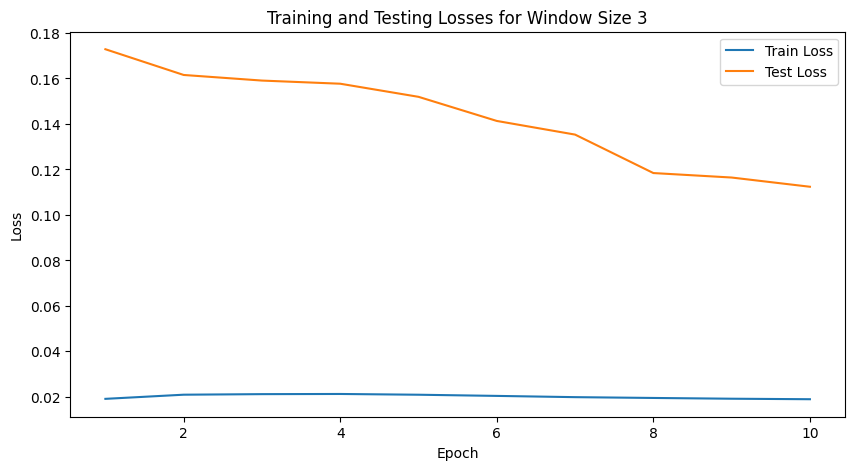

In [ ]:
n_epochs = 10
ws = 3
train_and_plot_losses(RNN_model, train_inout_seq_3, test_inout_seq_3, loss_function, RNN_optimizer, n_epochs, ws)


Window Size: 30
Epoch [1/10] - Train Loss: 0.0322 - Test Loss: 0.1543
Epoch [2/10] - Train Loss: 0.0255 - Test Loss: 0.1414
Epoch [3/10] - Train Loss: 0.0240 - Test Loss: 0.1605
Epoch [4/10] - Train Loss: 0.0267 - Test Loss: 0.1633
Epoch [5/10] - Train Loss: 0.0251 - Test Loss: 0.1681
Epoch [6/10] - Train Loss: 0.0265 - Test Loss: 0.1738
Epoch [7/10] - Train Loss: 0.0256 - Test Loss: 0.1728
Epoch [8/10] - Train Loss: 0.0257 - Test Loss: 0.1711
Epoch [9/10] - Train Loss: 0.0262 - Test Loss: 0.1947
Epoch [10/10] - Train Loss: 0.0252 - Test Loss: 0.1586


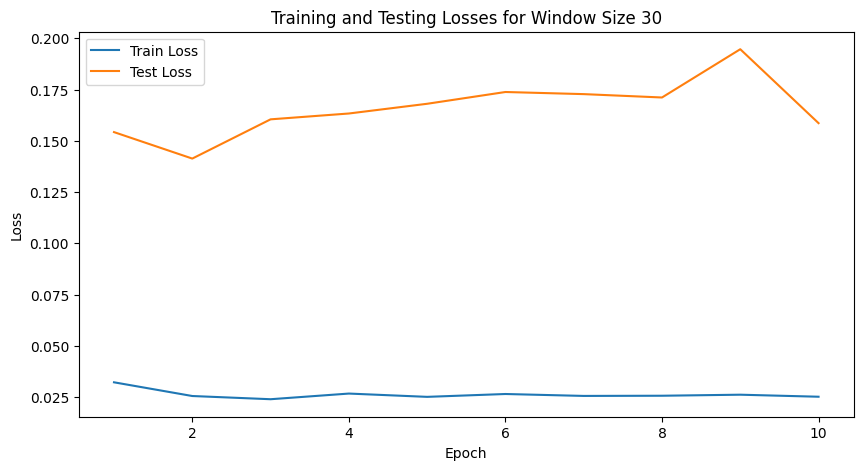

In [ ]:
n_epochs = 10
ws = 30

train_and_plot_losses(RNN_model, train_inout_seq_30, test_inout_seq_30, loss_function, RNN_optimizer, n_epochs, ws)


Window Size: 100
Epoch [1/5] - Train Loss: 0.0298 - Test Loss: 0.1515
Epoch [2/5] - Train Loss: 0.0274 - Test Loss: 0.1539
Epoch [3/5] - Train Loss: 0.0259 - Test Loss: 0.1791
Epoch [4/5] - Train Loss: 0.0255 - Test Loss: 0.1852
Epoch [5/5] - Train Loss: 0.0251 - Test Loss: 0.1801


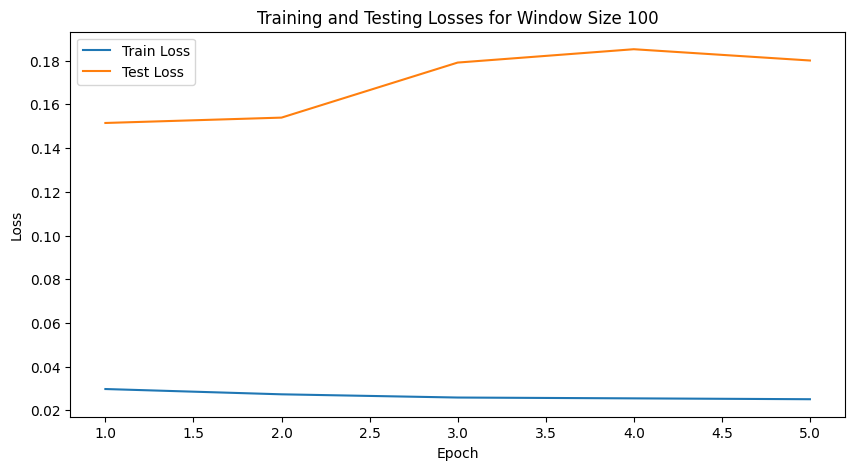

In [ ]:
n_epochs = 5
ws = 100

train_and_plot_losses(RNN_model, train_inout_seq_100, test_inout_seq_100, loss_function, RNN_optimizer, n_epochs, ws)


Window Size: 300
Epoch [1/5] - Train Loss: 0.0250 - Test Loss: 0.1933
Epoch [2/5] - Train Loss: 0.0244 - Test Loss: 0.1896
Epoch [3/5] - Train Loss: 0.0260 - Test Loss: 0.1949
Epoch [4/5] - Train Loss: 0.0255 - Test Loss: 0.1950
Epoch [5/5] - Train Loss: 0.0251 - Test Loss: 0.1962


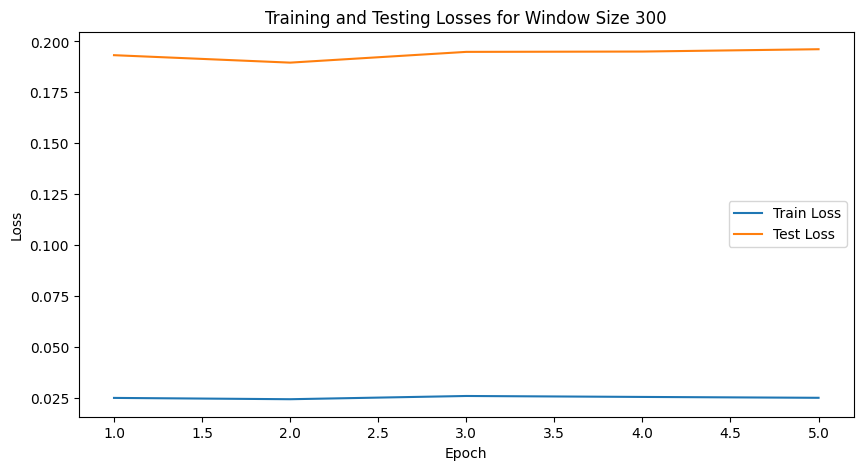

In [ ]:
n_epochs = 5
ws = 300

train_and_plot_losses(RNN_model, train_inout_seq_300, test_inout_seq_300, loss_function, RNN_optimizer, n_epochs, ws)


Window Size: 3
Epoch [1/10] - Train Loss: 0.0244 - Test Loss: 0.1211
Epoch [2/10] - Train Loss: 0.0254 - Test Loss: 0.1058
Epoch [3/10] - Train Loss: 0.0243 - Test Loss: 0.0924
Epoch [4/10] - Train Loss: 0.0237 - Test Loss: 0.0803
Epoch [5/10] - Train Loss: 0.0232 - Test Loss: 0.0733
Epoch [6/10] - Train Loss: 0.0230 - Test Loss: 0.0697
Epoch [7/10] - Train Loss: 0.0230 - Test Loss: 0.0660
Epoch [8/10] - Train Loss: 0.0229 - Test Loss: 0.0686
Epoch [9/10] - Train Loss: 0.0230 - Test Loss: 0.0628
Epoch [10/10] - Train Loss: 0.0230 - Test Loss: 0.0629


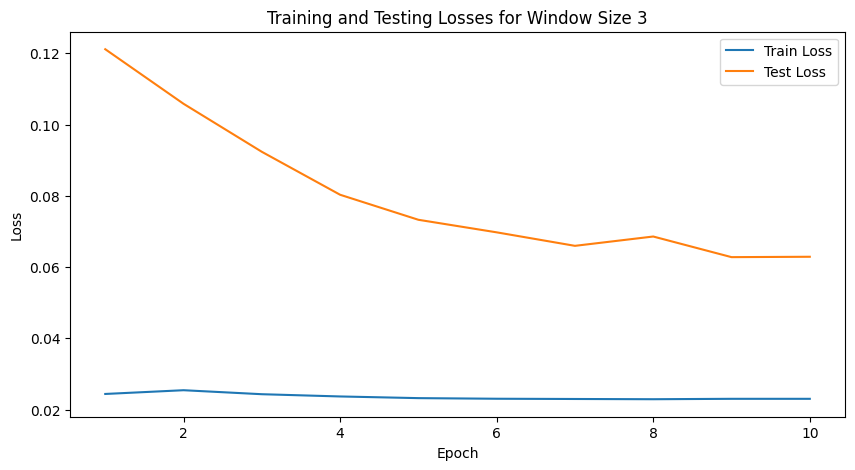

In [ ]:
n_epochs = 10
ws = 3

train_and_plot_losses(LSTM_model, train_inout_seq_3, test_inout_seq_3, loss_function, LSTM_optimizer, n_epochs, ws)


Window Size: 30
Epoch [1/10] - Train Loss: 0.0225 - Test Loss: 0.0636
Epoch [2/10] - Train Loss: 0.0225 - Test Loss: 0.0638
Epoch [3/10] - Train Loss: 0.0225 - Test Loss: 0.0623
Epoch [4/10] - Train Loss: 0.0224 - Test Loss: 0.0616
Epoch [5/10] - Train Loss: 0.0224 - Test Loss: 0.0606
Epoch [6/10] - Train Loss: 0.0224 - Test Loss: 0.0596
Epoch [7/10] - Train Loss: 0.0223 - Test Loss: 0.0593
Epoch [8/10] - Train Loss: 0.0223 - Test Loss: 0.0595
Epoch [9/10] - Train Loss: 0.0222 - Test Loss: 0.0590
Epoch [10/10] - Train Loss: 0.0222 - Test Loss: 0.0592


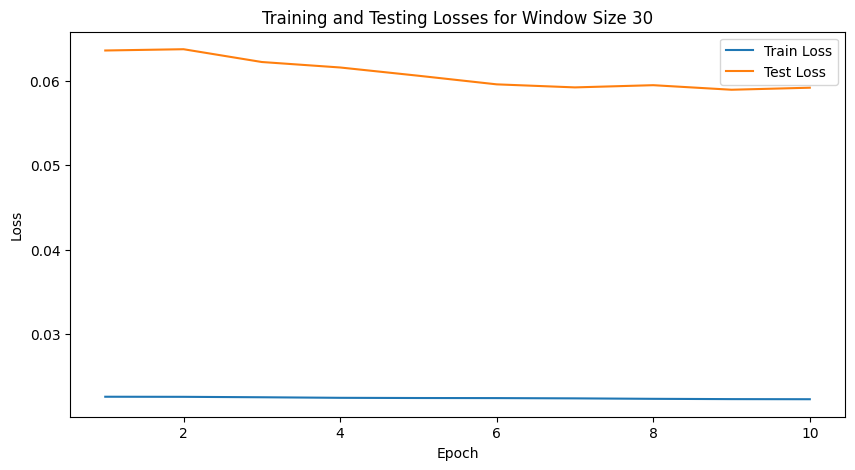

In [ ]:
n_epochs = 10
ws = 30

train_and_plot_losses(LSTM_model, train_inout_seq_30, test_inout_seq_30, loss_function, LSTM_optimizer, n_epochs, ws)


Window Size: 100
Epoch [1/5] - Train Loss: 0.0223 - Test Loss: 0.0591
Epoch [2/5] - Train Loss: 0.0223 - Test Loss: 0.0585
Epoch [3/5] - Train Loss: 0.0222 - Test Loss: 0.0579
Epoch [4/5] - Train Loss: 0.0222 - Test Loss: 0.0578
Epoch [5/5] - Train Loss: 0.0222 - Test Loss: 0.0575


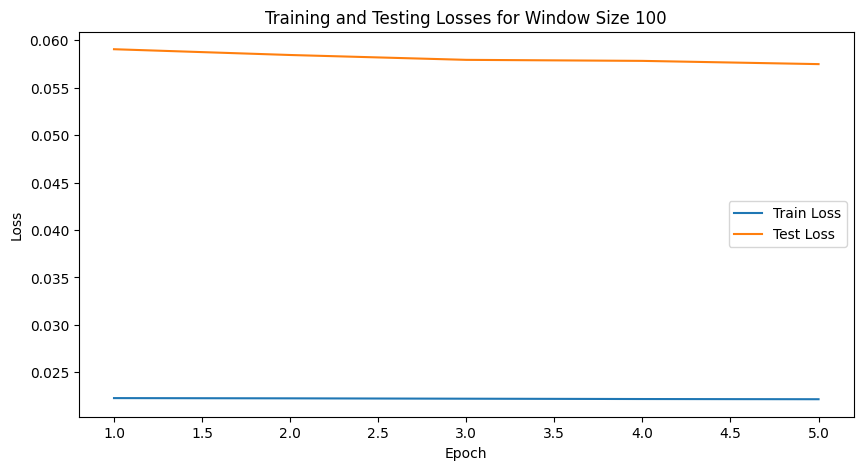

In [ ]:
n_epochs = 5
ws = 100

train_and_plot_losses(LSTM_model, train_inout_seq_100, test_inout_seq_100, loss_function, LSTM_optimizer, n_epochs, ws)


Window Size: 300
Epoch [1/5] - Train Loss: 0.0219 - Test Loss: 0.0596
Epoch [2/5] - Train Loss: 0.0219 - Test Loss: 0.0592
Epoch [3/5] - Train Loss: 0.0219 - Test Loss: 0.0588
Epoch [4/5] - Train Loss: 0.0219 - Test Loss: 0.0584
Epoch [5/5] - Train Loss: 0.0218 - Test Loss: 0.0580


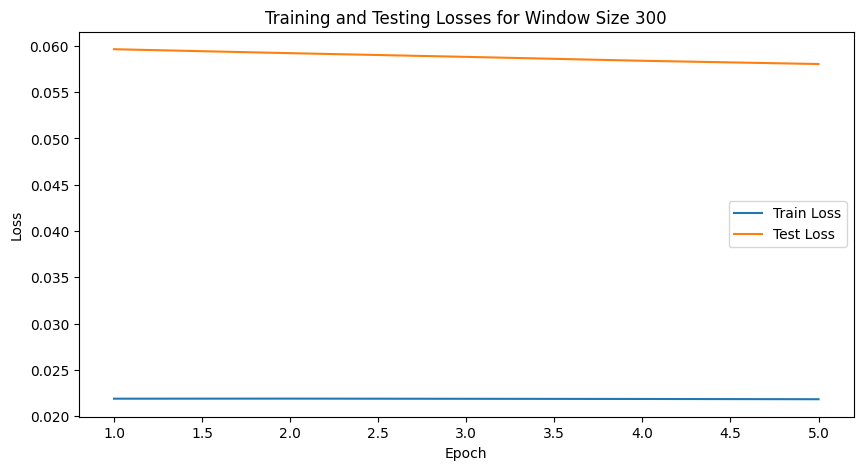

In [ ]:
n_epochs = 5
ws = 300

train_and_plot_losses(LSTM_model, train_inout_seq_300, test_inout_seq_300, loss_function, LSTM_optimizer, n_epochs, ws)


#Model Prediction Vs Real Values

In [ ]:

def generate_predictions(model, test_inout_seq, model_name, window_size):

    model.eval()

    prediction = []
    real_value = []

    for i in range(len(test_inout_seq)):
        input_data = torch.Tensor(test_inout_seq[i][0].reshape(1, window_size, 1))
        #prediction.append(model(torch.Tensor(test_inout_seq_300[i][0].reshape(1,300,1))).detach())

        prediction.append(model(input_data).detach())
        real_value.append(test_inout_seq[i][1])

    # Plotting the predictions and real values
    plt.figure(figsize=(10, 6))
    plt.plot(real_value, label='Real Values', color='green')
    plt.plot(prediction, label='Predictions', color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f'{model_name} Model Predictions vs Real Values')
    plt.show()



/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


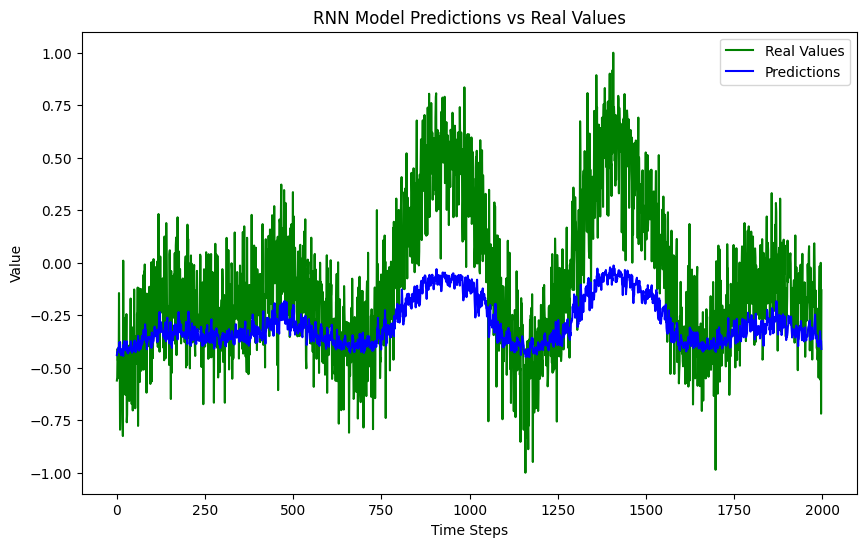

In [ ]:
window_size = 300
generate_predictions(RNN_model, test_inout_seq_300, 'RNN', window_size)

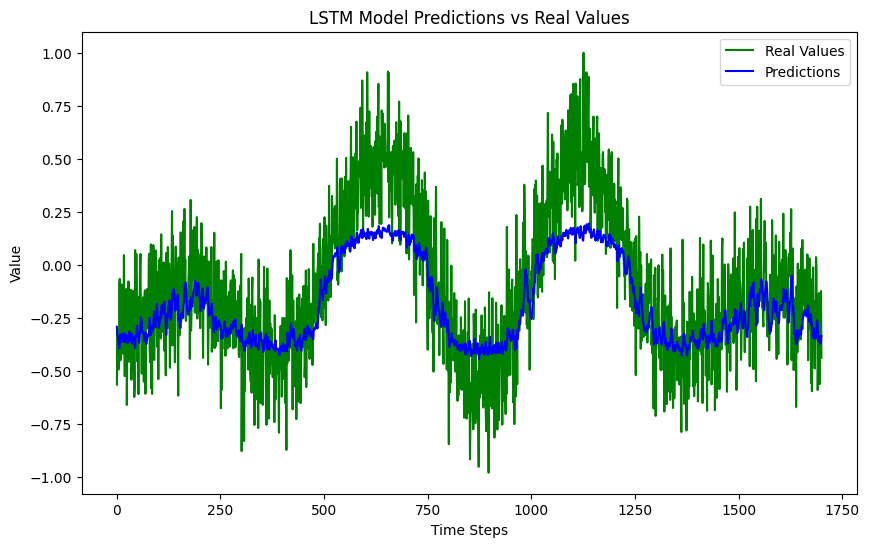

In [ ]:
generate_predictions(LSTM_model, test_inout_seq_300, 'LSTM')

#Future Predictions

In [ ]:
import numpy
def generate_future_predictions(model, input_data, future_length, window_size):
    predictions = []

    model.eval()
    with torch.no_grad():
        for i in range(future_length):
            predicted_value = model(torch.Tensor(input_data.reshape(1, window_size, 1)))

            predictions.append(predicted_value.item())

            input_data = numpy.roll(input_data, -1)
            input_data[-1] = predicted_value.item()

    return predictions



In [ ]:
tw = 300
input = normalised_train[-300:]
RNN_predictions = generate_future_predictions(RNN_model, input, 5000, tw)

In [ ]:
LSTM_predictions = generate_future_predictions(LSTM_model, input, 5000, tw)

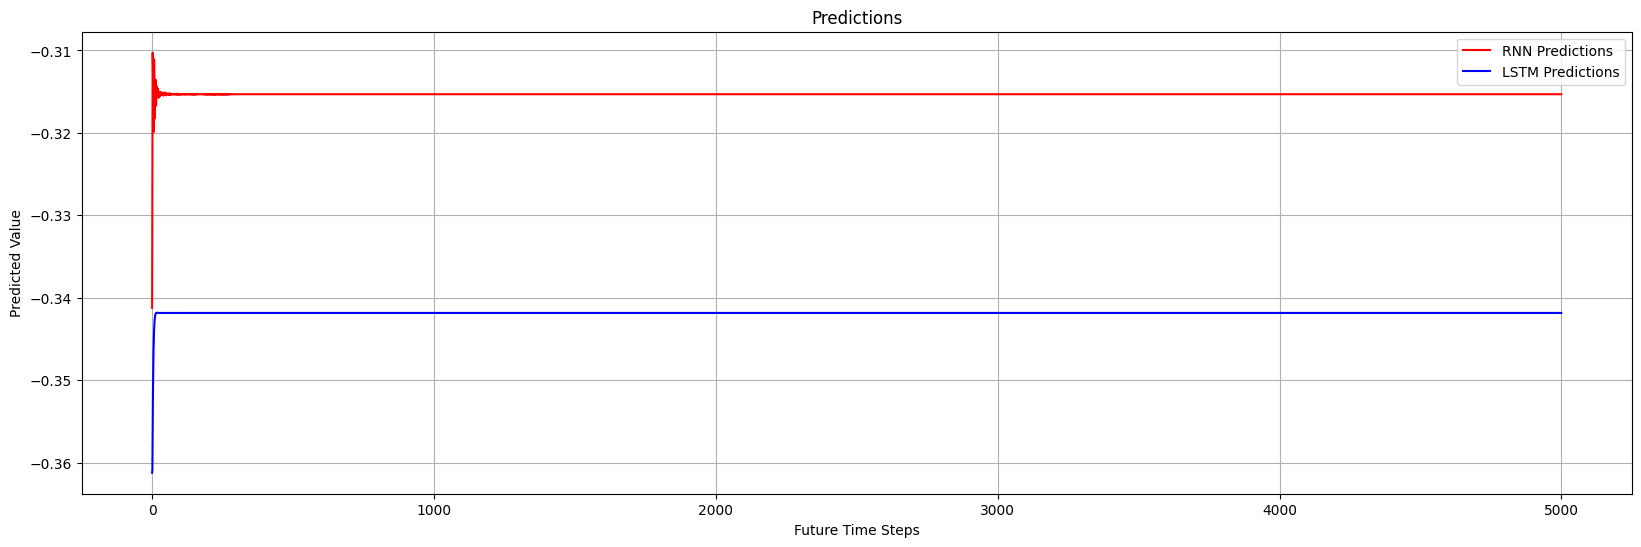

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(RMM_predictions, label="RNN Predictions", color="red")
plt.plot(LSTM_predictions, label="LSTM Predictions", color="blue")
plt.title("Predictions")
plt.xlabel("Future Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
plt.grid(True)
plt.show()

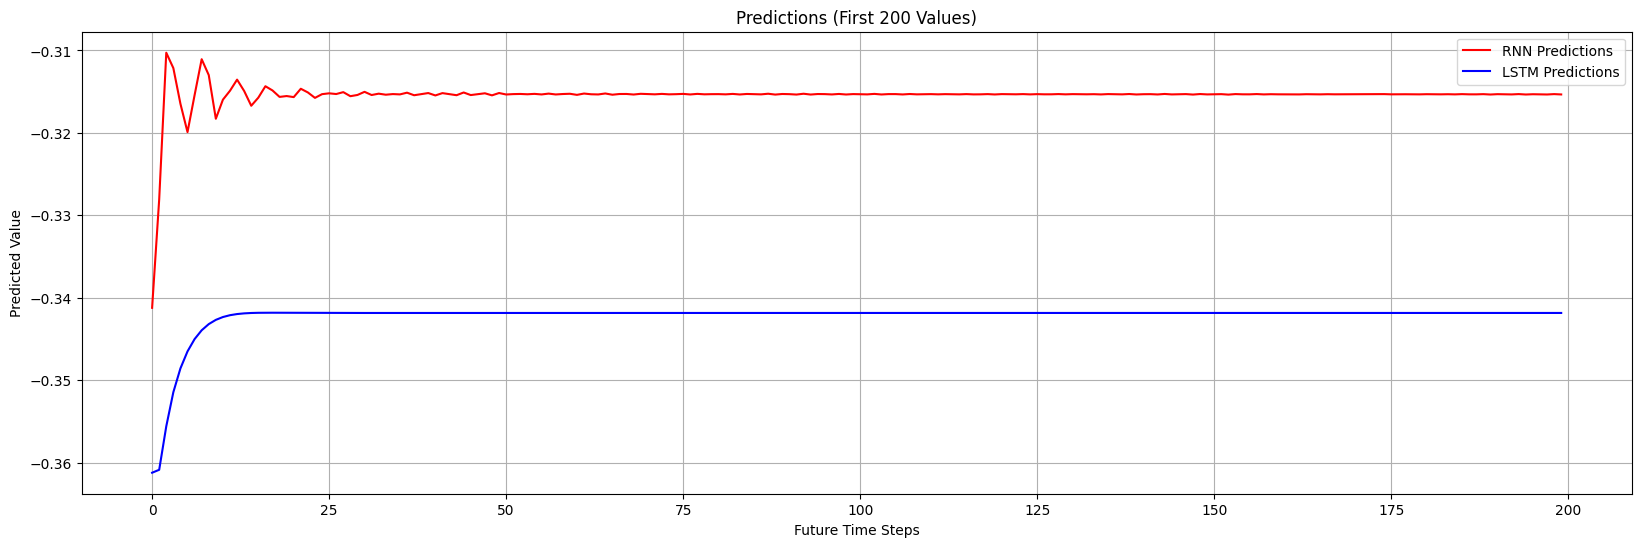

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(RMM_predictions[:200], label="RNN Predictions", color="red")
plt.plot(LSTM_predictions[:200], label="LSTM Predictions", color="blue")
plt.title("Predictions (First 200 Values)")
plt.xlabel("Future Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
plt.grid(True)
plt.show()


LSTM has a better prediction Horizon, because It's loss is less compared to RNN for all the window sizes. Also from the model prediction plot it can be seen that LSTM can able to predict better than RNN in this given dataset. LSTMs have gating mechanisms that help mitigate the vanishing gradient problem, enabling them to model more complex and longer-term patterns in sequential data